# Goals

We are going to build a simple CB-IAM, based on the SC-IAM we built in Lab 3.

To do that, we need:
 - A model of emissions
 - Estimates of mitigation costs
 - An optimization step

# Get a new dataset

The dataset comes from the ENGAGE project, an intermodel comparison of DP-IAMs:
https://data.ene.iiasa.ac.at/engage/#/downloads

The full dataset is 95 MB and includes 9 PB-IAMs and 182 scenarios:
https://www.dropbox.com/s/u3drzbpl91r331z/ENGAGE_scenario_data_world_r2.0.csv?dl=0

We are just going to use the data from one DP-IAM called AIM/CGE which includes a computational general equilibrium model and a sophisticated energy system. And we are only going to use the "no policy" scenario.

Download the file from
https://www.dropbox.com/s/dqh0lj3h2xgxbxm/aimcge-np.csv?dl=0

In [ ]:
input = read.csv("~/Open Modeling Group Dropbox/Climate Change Economics/labs/lab5/aimcge-np.csv")

* What does the data look like?
* What variables are in the data?

In [ ]:
library(reshape2)

In [ ]:
input2 = melt(input, c('Model', 'Scenario', 'Region', 'Variable', 'Unit'))

In [ ]:
input2 = subset(input2, !is.na(value))

In [ ]:
input2$year = as.numeric(substring(input2$variable, 2, 5))

In [ ]:
temp = subset(input2, Variable == 'Diagnostics|MAGICC6|Temperature|Global Mean')

* How can we plot these data?

In [ ]:
library(ggplot2)
ggplot(input2[grep("Primary Energy\\|", input2$Variable),], aes(year, value, fill=Variable)) + geom_col()

In [ ]:
ggplot(input2[grep("Final Energy\\|[^|]+$", input2$Variable),], aes(year, value, fill=Variable)) + geom_col()

In [ ]:
ggplot(input2[grep("Final Energy\\|Transportation\\|", input2$Variable),], aes(year, value, fill=Variable)) + geom_col()

# A common baseline

Let's get a common version of our final model from Lab 3, modified to use this new data.

In [ ]:
## Parameters
RR = 3.8 # Forcing at 2x CO2
C0 = 280 # Pre-industrial CO2
c = 0.098 # reaction rate of atmosphere
ECS = 3 # Equilibrium climate sensitivity
alpha = 1.0038 # Damage function scale
c.1960 = 3585.427 # GDP p.c. in 1960
c.2020 = 10542.301 # GDP p.c. in 2020
eta = 1.45 # Elasticity of marginal consumption

## Load the CO2 concentrations
co2 = read.csv("~/groups/ccecon/labs/lab3 - social cost of carbon/co2_ppm.csv")
## Select the SSP2-4.5 scenario for concentrations after 1960
co2.ssp245 = subset(co2, scenario == 'ssp245' & year > 1960)

## Set up the initial values: T_1960 = 0.2 C.
df = data.frame(year=1960, T=0.2, D=NA, cbar=NA, u=NA)
## Loop over all years from 1960 to 2300
for (tt in 1961:2300) {
  ## Retrieve the CO2 concentration in year tt
  C1 = co2.ssp245$value[co2.ssp245$year == tt]
  ## Calculate the radiative foring
  F = (RR / log(2)) * log(C1 / C0)
  ## Update the warming level, using the last row of df for the previous year
  T = df$T[nrow(df)] + c * (F - (RR / ECS) * df$T[nrow(df)])
  ## Compute the damages
  D = alpha * T^2
  ## Compute social welfare
  cbar = (c.2020 - c.1960) * (tt - 1960) / (2020 - 1960) + c.1960
  cc = cbar * (1 - D / 100)
  uu = (cc^(1 - eta)) / (1 - eta)
  ## Add on the results for the new year to df
  df = rbind(df, data.frame(year=tt, T=T, D=D, cbar, u=uu))
}

Now replace the CO2 concentration data.

In [ ]:
unique(input2$Variable[input2$Unit == 'ppm'])

In [ ]:
co2 = subset(input2, Variable == 'Diagnostics|MAGICC6|Concentration|CO2')

* What does it look like?

In [ ]:
## Parameters
RR = 3.8 # Forcing at 2x CO2
C0 = 280 # Pre-industrial CO2
c = 0.098 # reaction rate of atmosphere
ECS = 3 # Equilibrium climate sensitivity
alpha = 1.0038 # Damage function scale
c.1960 = 3585.427 # GDP p.c. in 1960
c.2020 = 10542.301 # GDP p.c. in 2020
eta = 1.45 # Elasticity of marginal consumption

## Set up the initial values: T_2009 from dataset
T.2009 = temp$value[temp$year == 2009]

## Loop over all years from 2010 to 2100
df = data.frame(year=2009, T=T.2009, D=NA, cbar=NA, u=NA)
for (tt in 2010:2100) {
  ## Retrieve the CO2 concentration in year tt
  C1 = co2$value[co2$year == tt]
  ## Calculate the radiative foring
  F = (RR / log(2)) * log(C1 / C0)
  ## Update the warming level, using the last row of df for the previous year
  T = df$T[nrow(df)] + c * (F - (RR / ECS) * df$T[nrow(df)])
  ## Compute the damages
  D = alpha * T^2
  ## Compute social welfare
  cbar = (c.2020 - c.1960) * (tt - 1960) / (2020 - 1960) + c.1960
  cc = cbar * (1 - D / 100)
  uu = (cc^(1 - eta)) / (1 - eta)
  ## Add on the results for the new year to df
  df = rbind(df, data.frame(year=tt, T=T, D=D, cbar, u=uu))
}

* Look at the results.

# Kaya identity emissions

We are going to use our simplified model of emissions, the Kaya identity.

* What is the Kaya identity?

In [ ]:
pop = subset(input2, Variable == ???)

In [ ]:
plot(pop$year, pop$value, type='l')

In [ ]:
gdp = subset(input2, Variable == ???)

In [ ]:
gdp$gdppc = gdp$value / pop$value

In [ ]:
plot(gdp$year, gdp$gdppc, type='l')

In [ ]:
energy = subset(input2, Variable == ???)

In [ ]:
energy$intensity = energy$value / gdp$value

In [ ]:
plot(energy$year, energy$intensity, type='l')

In [ ]:
emits = subset(input2, Variable == ???)

In [ ]:
plot(emits$year, emits$value, type='l')

In [ ]:
emits$intensity = emits$value / energy$value

In [ ]:
plot(emits$year, emits$intensity, type='l')

In [ ]:
plot(emits$year, pop$value * gdp$gdppc * energy$intensity * emits$intensity, type='l')

In [ ]:
emits$cigdp = emits$value / gdp$value

In [ ]:
plot(emits$year, pop$value * gdp$gdppc * emits$cigdp, type='l')

In [ ]:
future = data.frame(year=2010:2100, pop=approx(emits$year, pop$value, 2010:2100)$y,
                    gdppc=approx(gdp$year, gdp$gdppc, 2010:2100)$y,
                    cigdp=approx(emits$year, emits$cigdp, 2010:2100)$y)

In [ ]:
head(future)

We can use a simple OLS model to find the conversion from emissions to ppm.

$$ppm_t = \alpha + \beta \sum_{s \le t} emit_t + \epsilon_t$$

In [ ]:
yy = co2$value[co2$year >= 2010 & co2$year <= 2100]
xx = cumsum(future$pop * future$gdppc * future$cigdp)

In [ ]:
summary(lm(yy ~ xx))

Test it with emissions:

In [ ]:
emit2ppm = 7.385e-05

## Loop over all years from 2010 to 2100
df = data.frame(year=2009, C1=co2$value[co2$year == 2009],
                T=T.2009, D=NA, cbar=NA, u=NA)
for (tt in 2010:2100) {
  ## Retrieve the CO2 concentration in year tt
  C1 = df$C1[nrow(df)] + future$pop[tt-2009] * future$gdppc[tt-2009] * future$cigdp[tt-2009] * emit2ppm
  ## Calculate the radiative foring
  F = (RR / log(2)) * log(C1 / C0)
  ## Update the warming level, using the last row of df for the previous year
  T = df$T[nrow(df)] + c * (F - (RR / ECS) * df$T[nrow(df)])
  ## Compute the damages
  D = alpha * T^2
  ## Compute social welfare
  cc = future$gdppc[tt-2009] * (1 - D / 100)
  uu = (cc^(1 - eta)) / (1 - eta)
  ## Add on the results for the new year to df
  df = rbind(df, data.frame(year=tt, C1=C1, T=T, D=D, cbar=future$gdppc[tt-2009], u=uu))
}

In [ ]:
plot(df$year, df$T)

* What happens if we shut off emissions?

# Mitigation costs

We need an estimate of global mitigation costs. Let's use the McKinsey curve:
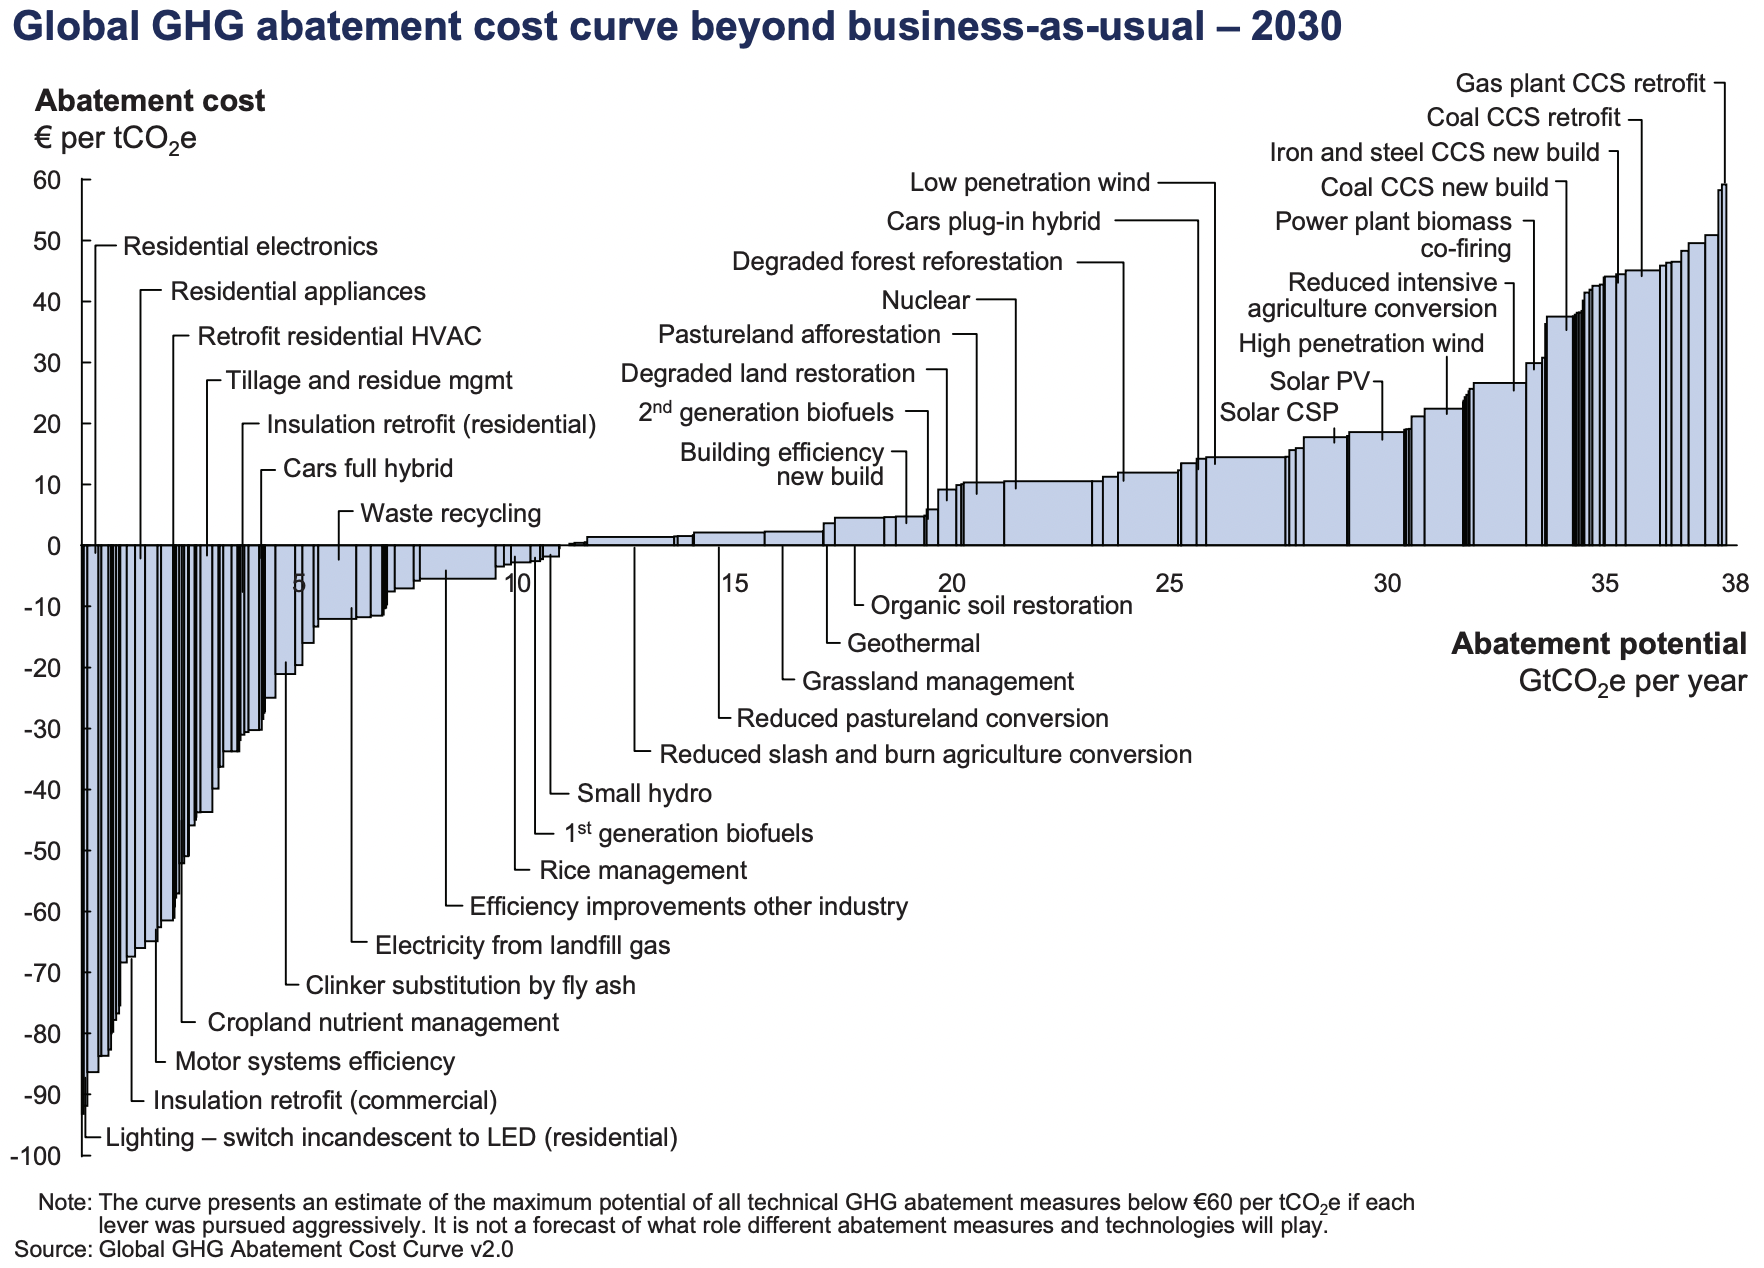

Let's break this up into multiple segments.

In [ ]:
xx = c(XXX)
yy = c(YYY)

In [ ]:
plot(xx, yy, type='l')
lines(c(0, 38), c(0, 0), col='grey')

## Some other considerations for mitigation costs

McKinsey curve is a theoretical ideal. It would be nice to account for:

1. Switching costs (to explain why people don't already apply no-regret gains)
2. Acellerated change costs (faster change means abandoning capital)
3. Lack of efficient ordering (working on changes across the MAC curve)

Define a reduction path as an exponential approach to 100% abatement.

In [ ]:
rate = 20
tt = 2010:2100
abate = ifelse(tt > 2022, 1 - exp(-(tt - 2022) / rate), 0)

In [ ]:
plot(tt, abate)

In [ ]:
rate = 20

## Loop over all years from 2010 to 2100
df = data.frame(year=2009, C1=co2$value[co2$year == 2009],
                T=T.2009, D=NA, cbar=NA, u=NA)
for (tt in 2010:2100) {
    # Abatement
    abate = ifelse(tt > 2022, 1 - exp(-(tt - 2022) / rate), 0)
    ## Retrieve the CO2 concentration in year tt
    C1 = df$C1[nrow(df)] + future$pop[tt-2009] * future$gdppc[tt-2009] * future$cigdp[tt-2009] * (1 - abate) * emit2ppm
    ## Calculate the radiative foring
    F = (RR / log(2)) * log(C1 / C0)
    ## Update the warming level, using the last row of df for the previous year
    T = df$T[nrow(df)] + c * (F - (RR / ECS) * df$T[nrow(df)])
    ## Compute the damages
    D = alpha * T^2
    ## Compute social welfare
    cc = future$gdppc[tt-2009] * (1 - D / 100)
    uu = (cc^(1 - eta)) / (1 - eta)
    ## Add on the results for the new year to df
    df = rbind(df, data.frame(year=tt, C1=C1, T=T, D=D, cbar=future$gdppc[tt-2009], u=uu))
}

In [ ]:
plot(df$year, df$T)

Now add on abatement costs.

In [ ]:
xx = c(0, 5, 30, 38)
yy = c(-90, -15, 20, 50)
tac = function(gt) {
    tot = 0
    if (gt == 0)
        return(tot)
    for (ii in which(xx < gt)[-1]) {
        slope = (yy[ii] - yy[ii-1]) / (xx[ii] - xx[ii-1])
        tot = tot + slope * (xx[ii] - xx[ii-1])^2 + yy[ii-1] * (xx[ii] - xx[ii-1])
    }
    last = tail(which(xx < gt), 1)
    slope = (yy[last+1] - yy[last]) / (xx[last+1] - xx[last])
    tot = tot + slope * (gt - xx[last])^2 + yy[last] * (gt - xx[last])
    tot * 1e9 * 1.07
}

* How do we plot it?

## Acellerated change

Additional costs of mitigation equal to
$$GDP \left(\frac{dr}{dt}\right)^2$$

In [ ]:
rate = 20

## Loop over all years from 2010 to 2100
df = data.frame(year=2009, C1=co2$value[co2$year == 2009],
                T=T.2009, abate=NA, cost=NA, D=NA, cbar=NA, u=NA)
for (tt in 2010:2100) {
    # Abatement
    abate = ifelse(tt > 2022, 1 - exp(-(tt - 2022) / rate), 0)
    ## Cost of abatement (in % GDP)
    cost = 100 * (tac(abate * 38) / 84.71e12 + (abate - df$abate[nrow(df)])^2)
    ## Retrieve the CO2 concentration in year tt
    C1 = df$C1[nrow(df)] + future$pop[tt-2009] * future$gdppc[tt-2009] * future$cigdp[tt-2009] * (1 - abate) * emit2ppm
    ## Calculate the radiative foring
    F = (RR / log(2)) * log(C1 / C0)
    ## Update the warming level, using the last row of df for the previous year
    T = df$T[nrow(df)] + c * (F - (RR / ECS) * df$T[nrow(df)])
    ## Compute the damages
    D = alpha * T^2
    ## Compute social welfare
    cc = future$gdppc[tt-2009] * (1 - D / 100 - cost / 100)
    uu = (cc^(1 - eta)) / (1 - eta)
    ## Add on the results for the new year to df
    df = rbind(df, data.frame(year=tt, C1=C1, T=T, abate=abate, cost=cost, D=D, cbar=future$gdppc[tt-2009], u=uu))
}

In [ ]:
plot(df$year, df$cost)

In [ ]:
plot(df$year, df$D)

Wrap it in a function so we can do optimization:

In [ ]:
simulate = function(rate) {
    ## Loop over all years from 2010 to 2100
    df = data.frame(year=2009, C1=co2$value[co2$year == 2009],
                    T=T.2009, abate=NA, cost=NA, D=NA, cbar=NA, u=NA)
    for (tt in 2010:2100) {
        # Abatement
        abate = ifelse(tt > 2022, 1 - exp(-(tt - 2022) / rate), 0)
        ## Cost of abatement (in % GDP)
        cost = 100 * (tac(abate * 38) / 84.71e12 + (abate - df$abate[nrow(df)])^2)
        ## Retrieve the CO2 concentration in year tt
        C1 = df$C1[nrow(df)] + future$pop[tt-2009] * future$gdppc[tt-2009] * future$cigdp[tt-2009] * (1 - abate) * emit2ppm
        ## Calculate the radiative foring
        F = (RR / log(2)) * log(C1 / C0)
        ## Update the warming level, using the last row of df for the previous year
        T = df$T[nrow(df)] + c * (F - (RR / ECS) * df$T[nrow(df)])
        ## Compute the damages
        D = alpha * T^2
        ## Compute social welfare
        cc = future$gdppc[tt-2009] * (1 - D / 100 - cost / 100)
        uu = (cc^(1 - eta)) / (1 - eta)
        ## Add on the results for the new year to df
        df = rbind(df, data.frame(year=tt, C1=C1, T=T, abate=abate, cost=cost, D=D, cbar=future$gdppc[tt-2009], u=uu))
    }
    
    df
}

In [ ]:
df = simulate(0)

In [ ]:
plot(df$year, df$cost)

Let's compare a couple simulations

In [ ]:
df1 = simulate(AAA)
df2 = simulate(BBB)

In [ ]:
plot(df1$year, df1$u)
lines(df2$year, df2$u)

In [ ]:
plot(df1$year, df1$D + df1$cost)
lines(df2$year, df2$D + df2$cost)

In [ ]:
rho = 1.5 / 100
year0 = 2020

npv = function(rate) {
    df = simulate(rate)
    
    sum(df$u[df$year >= 2020] * (1 + rho)^(-(df$year[df$year >= 2020] - year0)))
}

In [ ]:
plot(0:50, sapply(0:50, npv))

In [ ]:
optimize(npv, c(0, 50), maximum=TRUE)

* Now simulate it!

In [ ]:
plot(df$year, df$T)

In [ ]:
plot(df$year, df$cost)

In [ ]:
plot(df$year, df$D)